In [1]:
# this in an analysis of TR for the second round of aaa. In this round, I used 1.5M NaCl instead of 0.5M NaCl as
# was used in the first round

import pandas as pd
import seaborn as sns
import numpy as np  
import numpy.matlib
import matplotlib.pyplot as plt 
from skimage import io
from skimage.feature import hog
from joblib import Parallel, delayed
import cv2
import glob
import matplotlib.patches as patches # for drawing rectangle on plot

In [2]:
sessions = ['../2020_06_22_aac10_d04_replete']
cam_configs = ['multicam', 'cam1', 'cam2']

#sessions = ['2020_05_16_aaa_d03_rereplete']
cam_configs = ['multicam']

In [3]:
# set parameters
rec_fps = 25  # frames per sec
rec_pre = 4   # sec
rec_inf = 2   # sec
rec_post = 6  # sec

In [4]:
n_loop = 0

for session in sessions:
    key_files = pd.read_excel(session + '/key_files.xlsx')
    for n_rec in range(key_files.shape[0]):
        for cam_config in cam_configs:
            sbj = key_files.subject[n_rec]
            
            cam1_sbj_pca = pd.read_csv('./' + session + '/' + sbj + '/' + sbj + '_sbj_multicam_pca100.csv')
            cam2_sbj_pca = pd.read_csv('./' + session + '/' + sbj + '/' + sbj + '_sbj_multicam_pca100.csv')
            multicam_sbj_pca = pd.read_csv('./' + session + '/' + sbj + '/' + sbj + '_sbj_multicam_pca100.csv')
            
            if n_loop == 0:
                cam1_sbj_pca_combined = cam1_sbj_pca
                cam2_sbj_pca_combined = cam2_sbj_pca
                multicam_sbj_pca_combined = multicam_sbj_pca
            else:
                cam1_sbj_pca_combined = pd.concat([cam1_sbj_pca_combined, cam1_sbj_pca],axis=0)
                cam2_sbj_pca_combined = pd.concat([cam2_sbj_pca_combined, cam2_sbj_pca],axis=0)
                multicam_sbj_pca_combined = pd.concat([multicam_sbj_pca_combined, multicam_sbj_pca],axis=0)
                
            n_loop = n_loop + 1

In [5]:
multicam_sbj_pca_combined.head(3)

,Unnamed: 0,trial,epoch,tastant,date,subject,state,0,1,2,...,90,91,92,93,94,95,96,97,98,99
0,0,1,bl,quinine,2020_05_12,aaa02,replete_baseline,1.471931,-0.403406,-0.460302,...,0.171489,-0.063435,-0.023440,0.064492,0.124528,-0.018339,0.106869,-0.070357,-0.016546,-0.033164
1,1,1,bl,quinine,2020_05_12,aaa02,replete_baseline,1.496269,-0.466576,-0.493090,...,0.171286,-0.056986,-0.015995,0.045233,0.131738,-0.005877,0.065961,-0.061458,-0.016436,-0.038431
2,2,1,bl,quinine,2020_05_12,aaa02,replete_baseline,1.450872,-0.449445,-0.460290,...,0.207723,-0.007719,0.036032,0.052226,0.105170,0.001797,0.102391,-0.057495,0.006009,-0.050521


In [6]:
# remove with updated pca data
frame_trial_num = []
n_trial = 1

for n in range(60):
    frame_trial_num = frame_trial_num + [n_trial] * (rec_pre + rec_inf + rec_post)*rec_fps
    n_trial = n_trial + 1

frame_trial_num = frame_trial_num * 15

multicam_sbj_pca_combined['trial'] = frame_trial_num

In [7]:
# create time bins
frame_time = np.arange(0,  (rec_pre + rec_inf + rec_post)*rec_fps , 1)
frame_time = frame_time * (1/rec_fps) - rec_pre
#frame_time = np.transpose(np.matlib.repmat(frame_time,1,15*60))
frame_time = np.matlib.repmat(frame_time,1,15*60)

frame_time_bin = pd.cut(frame_time.flatten(), bins = [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8], right = False)
#frame_time_bin = pd.cut(frame_time.flatten(), bins = [-4, -2, 0, 2, 4, 6, 8], right = False)
#frame_time_bin = pd.cut(frame_time.flatten(), bins = [-4, 0, 4, 8], right = False)

In [8]:
sbjs = multicam_sbj_pca_combined['subject'].unique()
tastants = multicam_sbj_pca_combined['tastant'].unique()
epochs = multicam_sbj_pca_combined['epoch'].unique()
states = multicam_sbj_pca_combined['state'].unique()
models = ['LogisticRegression', 
          'DecisionTreeClassifier', 
          'KNeighborsClassifier', 
          'SVC', 
          'svm.NuSVC', 
          'SGDClassifier', 
          'RBFSampler',
          'RandomForestClassifier',
          'ExtraTreesClassifier'
         ]
tm_bins = frame_time_bin.unique()

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import RBFSampler

from sklearn.model_selection import train_test_split
from sklearn import metrics

n_loop = 0
num_categorical_column = 7

for model in models:
    for tm_bin in tm_bins:
    #for epoch in epochs: # epoch based
        for state in states:
            for sbj in sbjs:
                data = multicam_sbj_pca_combined[(multicam_sbj_pca_combined['subject'] == sbj) & \
                                                 #(multicam_sbj_pca_combined['epoch'] == epoch) & \ # epoch based
                                                 (frame_time_bin == tm_bin) & \
                                                 (multicam_sbj_pca_combined['state'] == state) 
                                                ]

                y_stand = data[data['tastant']!='nacl']['tastant']
                cat_stand = data[data['tastant']!='nacl'].iloc[:,:num_categorical_column]
                x_stand = data[data['tastant']!='nacl'].iloc[:,num_categorical_column:] 
                
                trials = cat_stand['trial'].unique()
                trials_train, trials_test = train_test_split(trials, test_size=0.2, random_state=10)

                y_all = data['tastant']
                x_all = data.iloc[:,num_categorical_column:]

                y_nacl = data[data['tastant']=='nacl']['tastant']
                x_nacl = data[data['tastant']=='nacl'].iloc[:,num_categorical_column:]

                # Test sucrose vs quinine
                x_train = x_stand.loc[cat_stand['trial'].isin(trials_train)]
                x_test  = x_stand.loc[cat_stand['trial'].isin(trials_test)]
                
                y_train = y_stand.loc[cat_stand['trial'].isin(trials_train)]
                y_test  = y_stand.loc[cat_stand['trial'].isin(trials_test)]
                
                if (model == 'LogisticRegression'): 
                    model_sq   = LogisticRegression()
                    model_nacl = LogisticRegression()
                    
                if (model == 'DecisionTreeClassifier'): 
                    model_sq   = DecisionTreeClassifier()
                    model_nacl = DecisionTreeClassifier()
                    
                if (model == 'KNeighborsClassifier'): 
                    model_sq   = KNeighborsClassifier(15)
                    model_nacl = KNeighborsClassifier(15)
                    
                if (model == 'SVC'):
                    model_sq = SVC()
                    model_nacl = SVC()
                    
                if (model == 'svm.NuSVC'):
                    model_sq = svm.NuSVC(gamma='auto')
                    model_nacl = svm.NuSVC(gamma='auto')
                    
                if (model == 'SGDClassifier'):
                    model_sq = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
                    model_nacl = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
                    
                if (model == 'RBFSampler'):
                    rbf_feature = RBFSampler(gamma=1, random_state=1)
                    x_train = rbf_feature.fit_transform(x_train)
                    x_test = rbf_feature.fit_transform(x_test)
                    x_stand = rbf_feature.fit_transform(x_stand)
                    x_nacl = rbf_feature.fit_transform(x_nacl)
                    
                    model_sq = SGDClassifier(max_iter=5)
                    model_nacl = SGDClassifier(max_iter=5)
                    
                if (model == 'DecisionTreeClassifier'):
                    model_sq = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)
                    model_nacl = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)
                    
                if (model == 'ExtraTreesClassifier'):
                    model_sq = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
                    model_nacl = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)

                    
                model_sq.fit(x_train, y_train)

                predictions = model_sq.predict(x_test)

                # Use score method to get accuracy of model
                score = model_sq.score(x_test, y_test)
                cm = metrics.confusion_matrix(y_test, predictions)

                # Test nacl
                model_nacl.fit(x_stand, y_stand)
                predictions = model_nacl.predict(x_nacl)

                
                nacl_predict_sucrose = sum(predictions == 'sucrose')
                nacl_predict_quinine = sum(predictions == 'quinine')
                nacl_predict_sucrose_prct  = nacl_predict_sucrose / (nacl_predict_sucrose + nacl_predict_quinine)


                if(n_loop == 0):
                    classifier_performance = pd.DataFrame({
                        'model': model,
                        'sbj': [sbj],
                        #'epoch': [epoch], # epoch based
                        'tm_bin': [tm_bin], # tm_bin based
                        'accuracy': [score],
                        'state': [state],
                        'sq_confusion_0_0': [cm[0,0]],
                        'sq_confusion_0_1': [cm[0,1]],
                        'sq_confusion_1_0': [cm[1,0]],
                        'sq_confusion_1_1': [cm[1,1]],
                        'nacl_predict_sucrose': nacl_predict_sucrose,
                        'nacl_predict_quinine': nacl_predict_quinine,
                        'nacl_predict_sucrose_prct': nacl_predict_sucrose_prct
                    })
                else:
                    classifier_performance = pd.concat([
                            classifier_performance,
                            pd.DataFrame({
                                'model': model,
                                'sbj': [sbj],
                                #'epoch': [epoch], # epoch based
                                'tm_bin': [tm_bin], # tm_bin based
                                'accuracy': [score],
                                'state': [state],
                                'sq_confusion_0_0': [cm[0,0]],
                                'sq_confusion_0_1': [cm[0,1]],
                                'sq_confusion_1_0': [cm[1,0]],
                                'sq_confusion_1_1': [cm[1,1]],
                                'nacl_predict_sucrose': nacl_predict_sucrose,
                                'nacl_predict_quinine': nacl_predict_quinine,
                                'nacl_predict_sucrose_prct': nacl_predict_sucrose_prct
                            })
                        ], axis = 0)

                n_loop = n_loop + 1

C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklea

C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklea

C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklea

C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklea

C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklea

C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklea

C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklea

C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklea

C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'aut

C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'aut

C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'aut

C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'aut

C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'aut

C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'aut

C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'aut

C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'aut

C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'aut

C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'aut

C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'aut

C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'aut

C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'aut

C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarnin

In [12]:
classifier_performance.sort_values(by=['accuracy'], ascending = False)

,model,sbj,tm_bin,accuracy,state,sq_confusion_0_0,sq_confusion_0_1,sq_confusion_1_0,sq_confusion_1_1,nacl_predict_sucrose,nacl_predict_quinine,nacl_predict_sucrose_prct
0,SGDClassifier,aaa07,"[7, 8)",1.000000,deplete,100,0,0,75,310,340,0.476923
0,SVC,aaa04,"[5, 6)",0.995000,deplete,75,0,1,124,139,361,0.278000
0,LogisticRegression,aaa04,"[5, 6)",0.995000,deplete,74,1,0,125,199,301,0.398000
0,svm.NuSVC,aaa07,"[7, 8)",0.994286,deplete,100,0,1,74,266,384,0.409231
0,SVC,aaa07,"[7, 8)",0.994286,deplete,100,0,1,74,274,376,0.421538
...,...,...,...,...,...,...,...,...,...,...,...,...
0,svm.NuSVC,aaa06,"[0, 1)",0.195556,replete_baseline,9,116,65,35,217,183,0.542500
0,KNeighborsClassifier,aaa06,"[-1, 0)",0.182222,replete_baseline,7,118,66,34,234,166,0.585000
0,KNeighborsClassifier,aaa03,"[1, 2)",0.137778,deplete,10,115,79,21,247,153,0.617500
0,KNeighborsClassifier,aaa02,"[-2, -1)",0.135000,replete_baseline,25,50,123,2,285,215,0.570000


In [13]:
classifier_performance['tm_bin_left'] = classifier_performance.apply(lambda x: x['tm_bin'].left, axis=1)

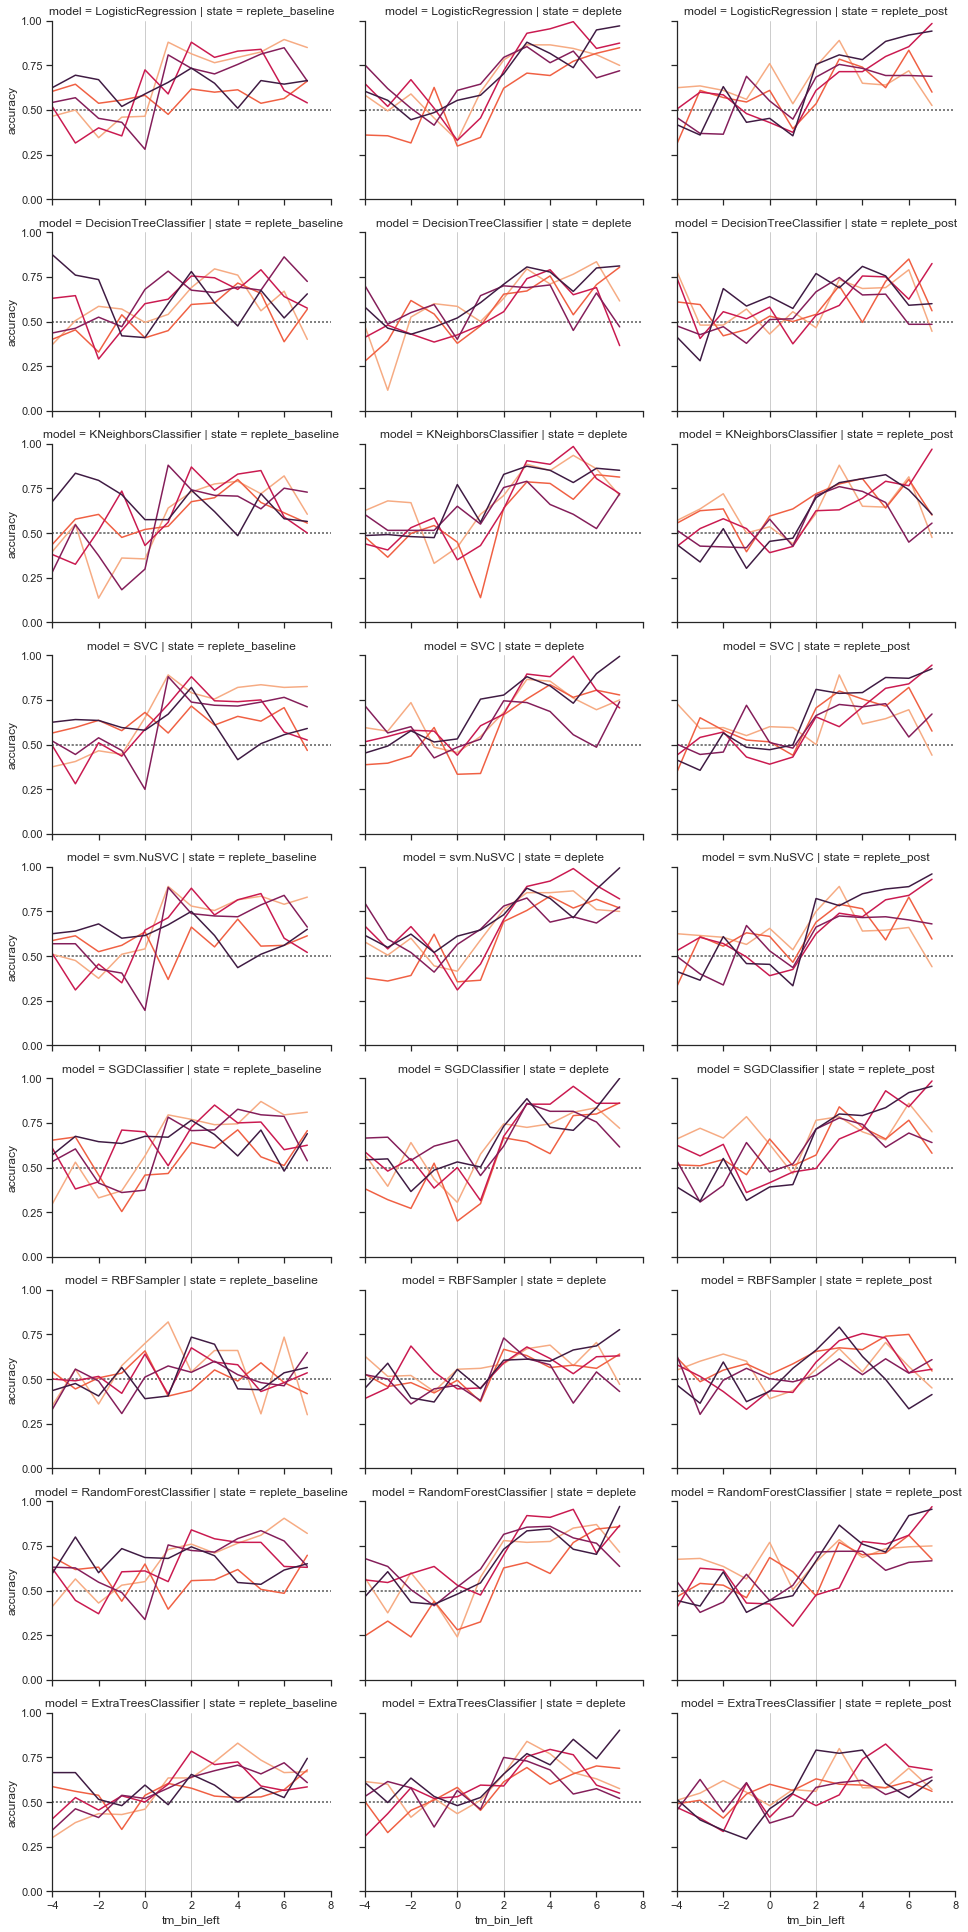

In [26]:


sns.set(style="ticks")
palette = dict(zip(classifier_performance.sbj.unique(),
                   sns.color_palette("rocket_r", 5)))

grid = sns.FacetGrid(classifier_performance, col="state", row = 'model', hue="sbj", palette=palette,
                     height=3, aspect = 1.5)

grid.map(plt.axhline, y=0.5, ls=":", c=".5")
grid.map(plt.axvline, x=0, c=".75", linewidth = 0.5, alpha = 0.5)
grid.map(plt.axvline, x=2, c=".75", linewidth = 0.5, alpha = 0.5)

grid.map(plt.plot, "tm_bin_left", "accuracy")

grid.set(xticks=np.arange(-4,10,2), yticks=[0, 0.25, 0.5, 0.75, 1],
         xlim=(-4, 8), ylim=(0, 1))

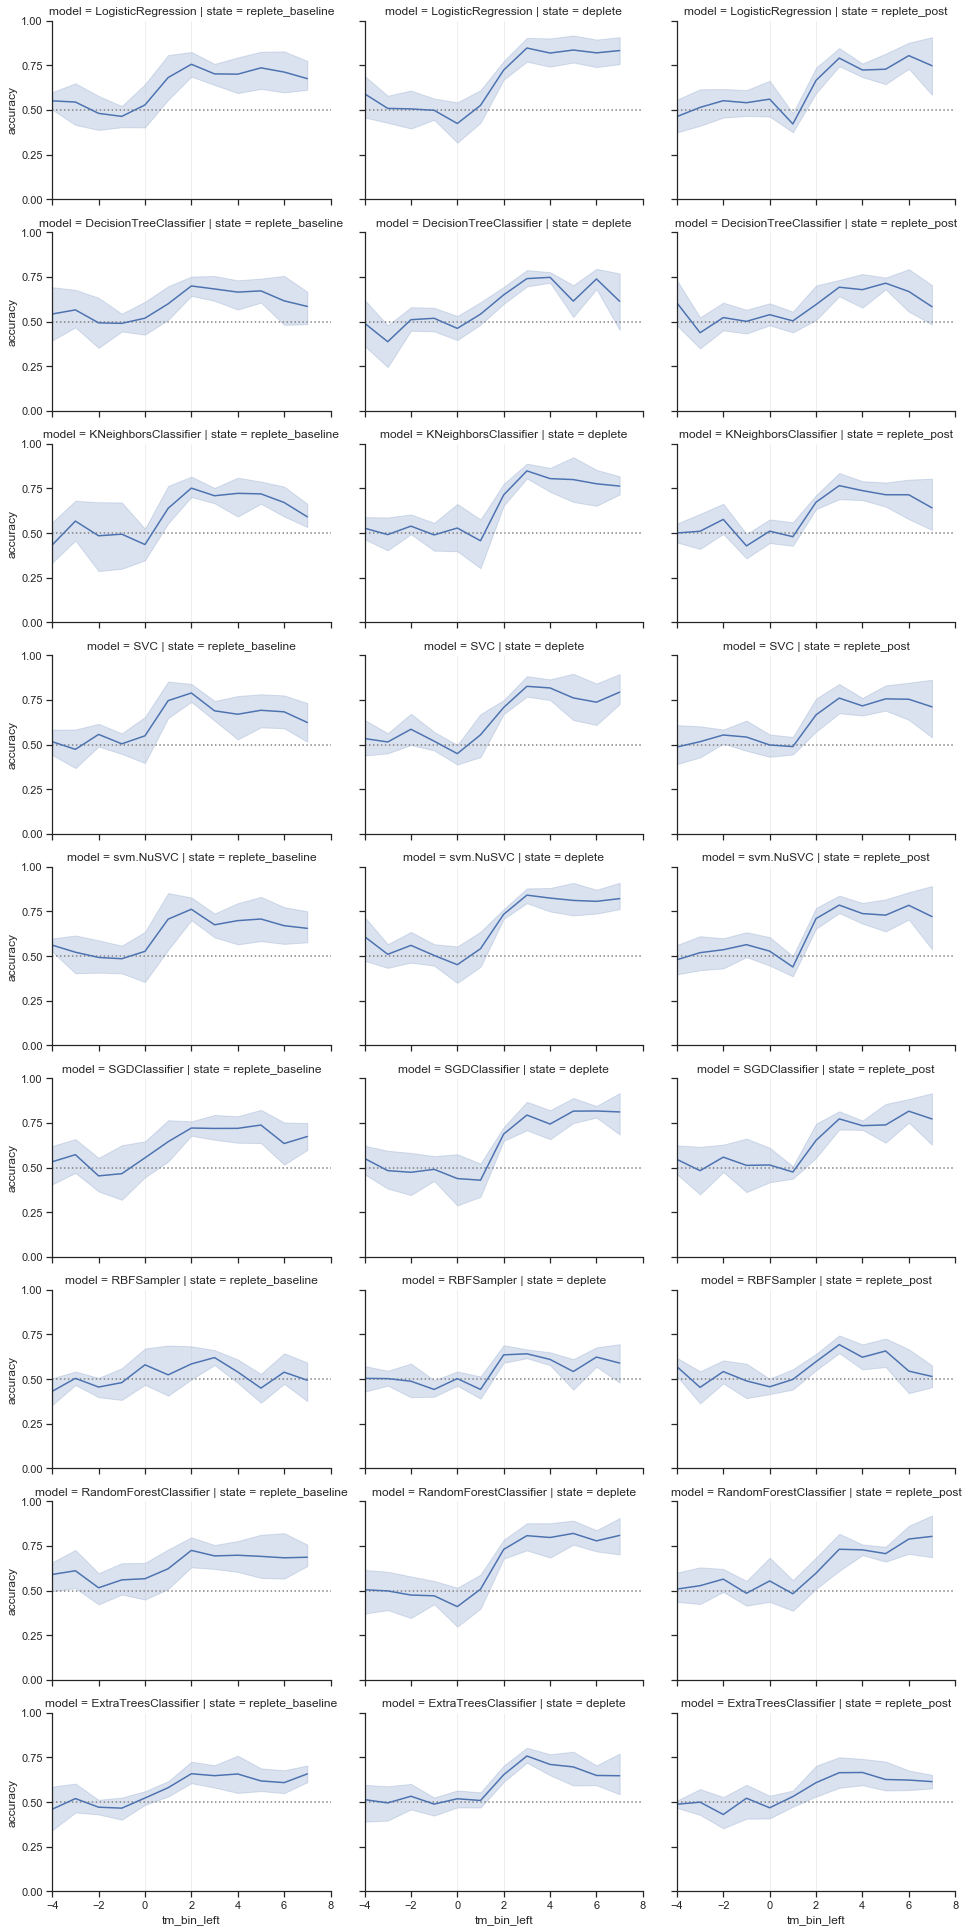

In [27]:
grid = sns.FacetGrid(classifier_performance, col="state", row = 'model', 
                     height=3, aspect = 1.5)

grid.map(plt.axhline, y=0.5, ls=":", c=".5")
grid.map(plt.axvline, x=0, c=".75", linewidth = 0.5, alpha = 0.5)
grid.map(plt.axvline, x=2, c=".75", linewidth = 0.5, alpha = 0.5)

grid.map(sns.lineplot, "tm_bin_left", "accuracy")

grid.set(xticks=np.arange(-4,10,2), yticks=[0, 0.25, 0.5, 0.75, 1],
         xlim=(-4, 8), ylim=(0, 1))

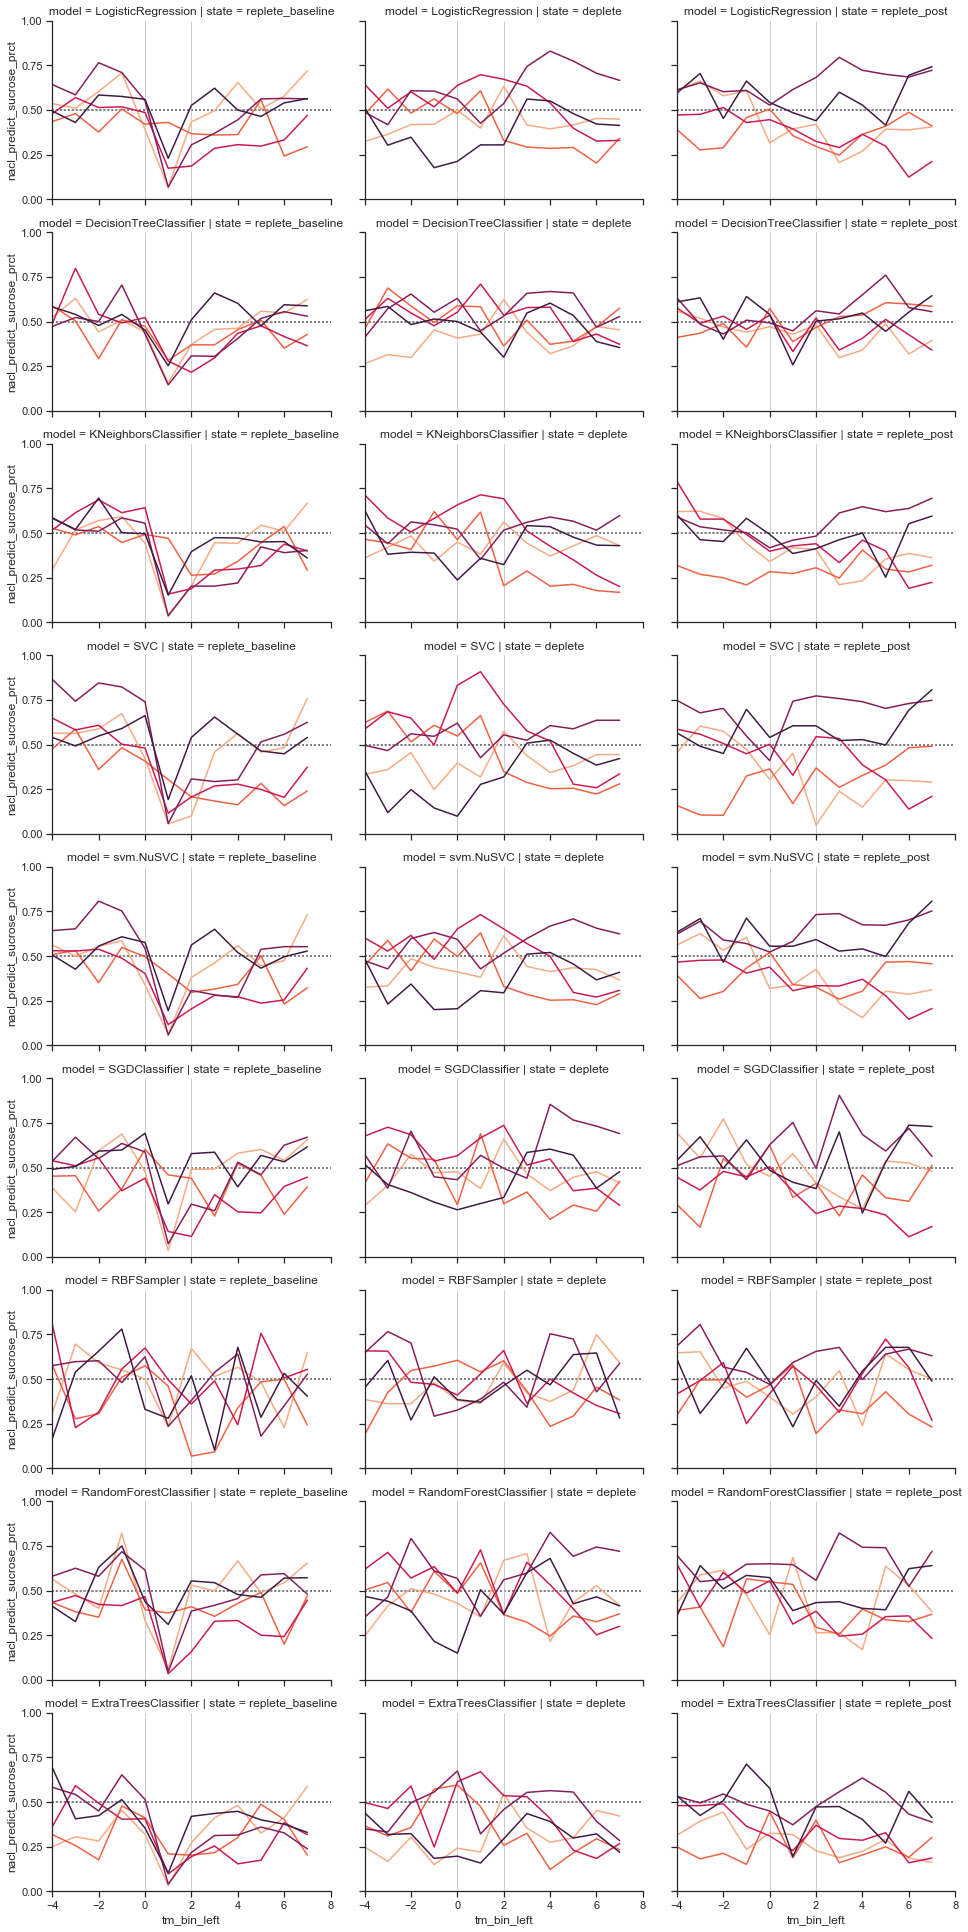

In [29]:
grid = sns.FacetGrid(classifier_performance, col="state", row = 'model', hue="sbj", palette=palette,
                     height=3, aspect = 1.5)

grid.map(plt.axhline, y=0.5, ls=":", c=".5")
grid.map(plt.axvline, x=0, c=".75", linewidth = 0.5, alpha = 0.5)
grid.map(plt.axvline, x=2, c=".75", linewidth = 0.5, alpha = 0.5)

grid.map(plt.plot, "tm_bin_left", "nacl_predict_sucrose_prct")

grid.set(xticks=np.arange(-4,10,2), yticks=[0, 0.25, 0.5, 0.75, 1],
         xlim=(-4, 8), ylim=(0, 1))

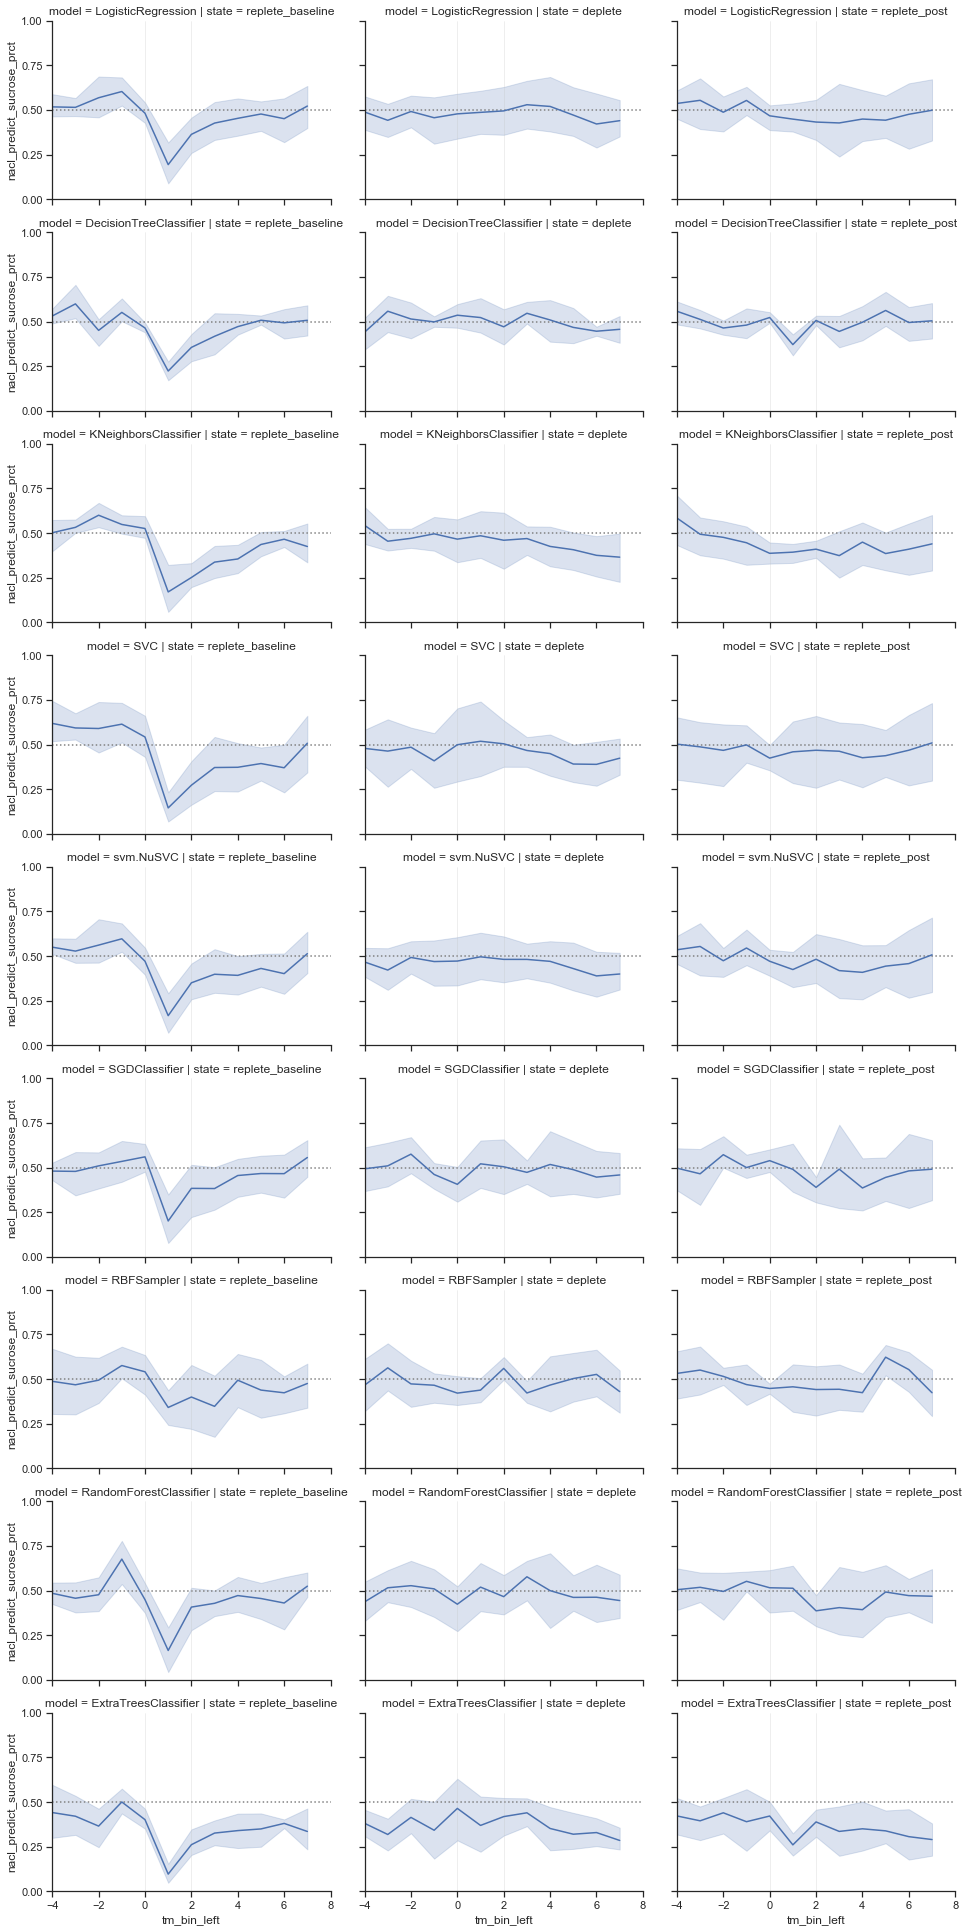

In [30]:
grid = sns.FacetGrid(classifier_performance, col="state", row = 'model', palette=palette,
                     height=3, aspect = 1.5)

# Draw a horizontal line to show the starting point
grid.map(plt.axhline, y=0.5, ls=":", c=".5")
grid.map(plt.axvline, x=0, c=".75", linewidth = 0.5, alpha = 0.5)
grid.map(plt.axvline, x=2, c=".75", linewidth = 0.5, alpha = 0.5)

# Draw a line plot to show the trajectory of each random walk
grid.map(sns.lineplot, "tm_bin_left", "nacl_predict_sucrose_prct")

# Adjust the tick positions and labels
grid.set(xticks=np.arange(-4,10,2), yticks=[0, 0.25, 0.5, 0.75, 1],
         xlim=(-4, 8), ylim=(0, 1))

In [18]:
# create summary
classifier_performance_summary = classifier_performance[classifier_performance['tm_bin_left'] > 1]
classifier_performance_summary = classifier_performance_summary.drop(['tm_bin', 'tm_bin_left'], axis = 1)
classifier_performance_summary = classifier_performance_summary.groupby(['model', 'state', 'sbj']).mean()
classifier_performance_summary = classifier_performance_summary.reset_index(drop=False)

classifier_performance_summary_model_order = classifier_performance_summary.groupby(['model']).mean().reset_index(drop=False).sort_values(by = ['accuracy'])
#classifier_performance_summary = classifier_performance_summary.sort_values(by = ['accuracy'])

In [31]:
classifier_performance_summary_model_order

,model,accuracy,sq_confusion_0_0,sq_confusion_0_1,sq_confusion_1_0,sq_confusion_1_1,nacl_predict_sucrose,nacl_predict_quinine,nacl_predict_sucrose_prct
4,RBFSampler,0.583093,62.033333,36.300000,50.233333,58.100000,227.666667,260.666667,0.466041
1,ExtraTreesClassifier,0.653677,81.266667,17.066667,54.855556,53.477778,165.477778,322.855556,0.341414
0,DecisionTreeClassifier,0.664059,70.411111,27.922222,41.688889,66.644444,233.922222,254.411111,0.480656
2,KNeighborsClassifier,0.728571,81.944444,16.388889,40.088889,68.244444,196.711111,291.622222,0.401870
7,SVC,0.730657,82.188889,16.144444,39.733333,68.600000,206.433333,281.900000,0.426709
5,RandomForestClassifier,0.737592,79.433333,18.900000,35.688889,72.644444,222.688889,265.644444,0.457990
6,SGDClassifier,0.742335,79.677778,18.655556,34.888889,73.444444,223.944444,264.388889,0.459934
8,svm.NuSVC,0.748604,82.633333,15.700000,36.488889,71.844444,211.011111,277.322222,0.436225
3,LogisticRegression,0.757030,81.144444,17.188889,33.388889,74.944444,223.588889,264.744444,0.461156


In [38]:
classifier_performance_summary.sort_values(by = ['accuracy']).tail(15)

,model,state,sbj,accuracy,sq_confusion_0_0,sq_confusion_0_1,sq_confusion_1_0,sq_confusion_1_1,nacl_predict_sucrose,nacl_predict_quinine,nacl_predict_sucrose_prct
50,LogisticRegression,replete_baseline,aaa02,0.824167,56.000000,19.000000,16.166667,108.833333,282.333333,217.666667,0.564667
30,KNeighborsClassifier,deplete,aaa02,0.825000,92.500000,7.500000,27.500000,72.500000,249.166667,300.833333,0.453030
107,SVC,deplete,aaa04,0.825000,63.000000,12.000000,23.000000,102.000000,224.500000,275.500000,0.449000
124,svm.NuSVC,deplete,aaa07,0.836190,95.666667,4.333333,24.333333,50.666667,276.833333,373.166667,0.425897
104,SGDClassifier,replete_post,aaa07,0.836296,107.833333,17.166667,19.666667,80.333333,221.666667,178.333333,0.554167
34,KNeighborsClassifier,deplete,aaa07,0.841905,92.833333,7.166667,20.500000,54.500000,296.666667,353.333333,0.456410
49,LogisticRegression,deplete,aaa07,0.842857,94.500000,5.500000,22.000000,53.000000,296.000000,354.000000,0.455385
119,SVC,replete_post,aaa07,0.842963,106.166667,18.833333,16.500000,83.500000,243.500000,156.500000,0.608750
77,RandomForestClassifier,deplete,aaa04,0.843333,65.500000,9.500000,21.833333,103.166667,208.833333,291.166667,0.417667
92,SGDClassifier,deplete,aaa04,0.843333,63.000000,12.000000,19.333333,105.666667,236.666667,263.333333,0.473333


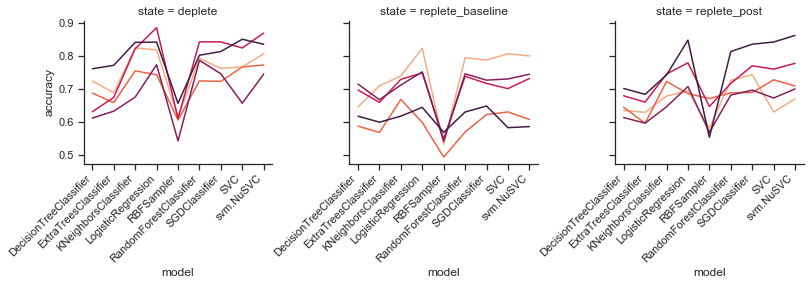

In [20]:
palette = dict(zip(classifier_performance_summary.sbj.unique(),
                   sns.color_palette("rocket_r", 5)))

grid = sns.FacetGrid(classifier_performance_summary, col="state", hue="sbj", palette=palette,
                     height=3, aspect = 1.25)

grid.map(plt.plot, "model", "accuracy")# order = classifier_performance_summary_model_order['model'])

grid.set_xticklabels(rotation=45, horizontalalignment='right')

#plt.xticks(rotation=90)

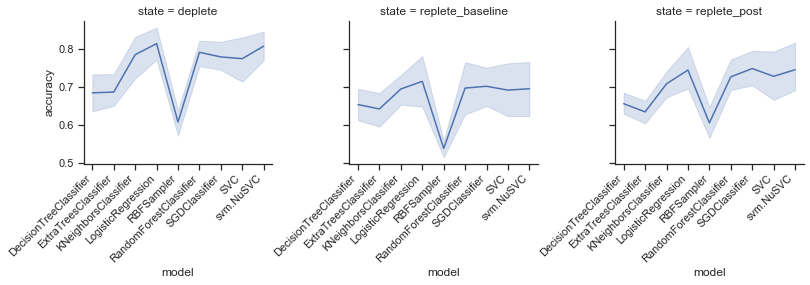

In [21]:
grid = sns.FacetGrid(classifier_performance_summary, col="state",
                     height=3, aspect = 1.25)


grid.map(sns.lineplot, "model", "accuracy")

grid.set_xticklabels(rotation=45, horizontalalignment='right')

#plt.xticks(rotation=90)

# trial by trial classification

In [66]:
predictions.shape[0]/25

np.tile([0,1],(1,2)) # python

array([[0, 1, 0, 1]])

In [73]:
data.index

Int64Index([  275,   276,   277,   278,   279,   280,   281,   282,   283,
              284,
            ...
            17990, 17991, 17992, 17993, 17994, 17995, 17996, 17997, 17998,
            17999],
           dtype='int64', length=1500)

In [81]:
sbjs = multicam_sbj_pca_combined['subject'].unique()
tastants = multicam_sbj_pca_combined['tastant'].unique()
epochs = multicam_sbj_pca_combined['epoch'].unique()
states = multicam_sbj_pca_combined['state'].unique()
models = ['LogisticRegression'
         ]
tm_bins = frame_time_bin.unique()

n_loop = 0
num_categorical_column = 7

for model in models:
    for tm_bin in tm_bins:
    #for epoch in epochs: # epoch based
        for state in states:
            for sbj in sbjs:
                data = multicam_sbj_pca_combined[(multicam_sbj_pca_combined['subject'] == sbj) & \
                                                 #(multicam_sbj_pca_combined['epoch'] == epoch) & \ # epoch based
                                                 (frame_time_bin == tm_bin) & \
                                                 (multicam_sbj_pca_combined['state'] == state) 
                                                ]

                y_stand = data[data['tastant']!='nacl']['tastant']
                cat_stand = data[data['tastant']!='nacl'].iloc[:,:num_categorical_column]
                x_stand = data[data['tastant']!='nacl'].iloc[:,num_categorical_column:]

                y_nacl = data[data['tastant']=='nacl']['tastant']
                x_nacl = data[data['tastant']=='nacl'].iloc[:,num_categorical_column:]
                
                data_trial = data[data['tastant']=='nacl']['trial']
                data_frame = data[data['tastant']=='nacl'].index
                
                model_nacl = LogisticRegression()
                    
                # Test nacl
                model_nacl.fit(x_stand, y_stand)
                predictions = model_nacl.predict(x_nacl)
                predict_probas = model_nacl.predict_proba(x_nacl)
                
                classifier_prediction_loop = pd.DataFrame({
                        'trial': data_trial,
                        'data_frame': data_frame,
                        'prediction': predictions,
                        'prediction_prob0': predict_probas[:,0],
                        'prediction_prob1': predict_probas[:,1]
                    })
                    
                classifier_prediction_loop['model'] = model
                classifier_prediction_loop['sbj'] = sbj
                classifier_prediction_loop['state'] = state
                classifier_prediction_loop['tm_bin'] = tm_bin

                if(n_loop == 0):
                    classifier_prediction = classifier_prediction_loop
                                                  
                else:
                    classifier_prediction = pd.concat([
                        classifier_prediction,
                        classifier_prediction_loop],
                        axis = 0)
                n_loop = n_loop + 1

C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklea

C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklea

C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklea

C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklea

C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda\lib\site-packages\sklea

In [82]:
classifier_prediction

,trial,data_frame,prediction,prediction_prob0,prediction_prob1,model,sbj,state,tm_bin
1200,5,1200,quinine,0.925204,0.074796,LogisticRegression,aaa02,replete_baseline,"[-4, -3)"
1201,5,1201,quinine,0.927818,0.072182,LogisticRegression,aaa02,replete_baseline,"[-4, -3)"
1202,5,1202,quinine,0.949023,0.050977,LogisticRegression,aaa02,replete_baseline,"[-4, -3)"
1203,5,1203,quinine,0.924521,0.075479,LogisticRegression,aaa02,replete_baseline,"[-4, -3)"
1204,5,1204,quinine,0.922875,0.077125,LogisticRegression,aaa02,replete_baseline,"[-4, -3)"
...,...,...,...,...,...,...,...,...,...
17695,59,17695,sucrose,0.005574,0.994426,LogisticRegression,aaa07,replete_post,"[7, 8)"
17696,59,17696,sucrose,0.006792,0.993208,LogisticRegression,aaa07,replete_post,"[7, 8)"
17697,59,17697,sucrose,0.008425,0.991575,LogisticRegression,aaa07,replete_post,"[7, 8)"
17698,59,17698,sucrose,0.010294,0.989706,LogisticRegression,aaa07,replete_post,"[7, 8)"


In [83]:
classifier_prediction.to_csv('./analysis/aaa/classifier_predictions.csv')

# model refinement

In [22]:
def GridSearchCV_sq(x_train, y_train, x_test, y_test, tuned_parameters):
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(
            SVC(), tuned_parameters, scoring='%s_macro' % score
        )
        clf.fit(x_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(x_test)
        print(classification_report(y_true, y_pred))
        print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

In [23]:
data = multicam_sbj_pca_combined[(multicam_sbj_pca_combined['subject'] == sbj) & \
                                         (frame_time_bin == tm_bin) & \
                                         (multicam_sbj_pca_combined['state'] == state) 
                                        ]

y_stand = data[data['tastant']!='nacl']['tastant']
cat_stand = data[data['tastant']!='nacl'].iloc[:,:num_categorical_column]
x_stand = data[data['tastant']!='nacl'].iloc[:,num_categorical_column:]

state

'replete_post'

In [ ]:
# SVC refinement
## optomize SVC for the 2nd second of response (bin has increase in accuracy and effect for nacl)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

tm_bin = frame_time_bin.unique()[7]

n_loop = 0
num_categorical_column = 7

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for state in states:
    for sbj in sbjs:
        data = multicam_sbj_pca_combined[(multicam_sbj_pca_combined['subject'] == sbj) & \
                                         (frame_time_bin == tm_bin) & \
                                         (multicam_sbj_pca_combined['state'] == state) 
                                        ]

        y_stand = data[data['tastant']!='nacl']['tastant']
        cat_stand = data[data['tastant']!='nacl'].iloc[:,:num_categorical_column]
        x_stand = data[data['tastant']!='nacl'].iloc[:,num_categorical_column:]

        trials = cat_stand['trial'].unique()
        trials_train, trials_test = train_test_split(trials, test_size=0.2, random_state=10)

        y_all = data['tastant']
        x_all = data.iloc[:,num_categorical_column:]

        y_nacl = data[data['tastant']=='nacl']['tastant']
        x_nacl = data[data['tastant']=='nacl'].iloc[:,num_categorical_column:]

        # Test sucrose vs quinine
        x_train = x_stand.loc[cat_stand['trial'].isin(trials_train)]
        x_test  = x_stand.loc[cat_stand['trial'].isin(trials_test)]

        y_train = y_stand.loc[cat_stand['trial'].isin(trials_train)]
        y_test  = y_stand.loc[cat_stand['trial'].isin(trials_test)]

        model_sq = SVC()
        model_sq = GridSearchCV(model_sq, param_grid = tuned_parameters)
        
        model_sq.fit(x_train, y_train)
        model_nacl = model_sq
    
        predictions = model_sq.predict(x_test)

        # Use score method to get accuracy of model
        score = model_sq.score(x_test, y_test)
        cm = metrics.confusion_matrix(y_test, predictions)

        # Test nacl
        model_nacl.fit(x_stand, y_stand)
        predictions = model_nacl.predict(x_nacl)


        nacl_predict_sucrose = sum(predictions == 'sucrose')
        nacl_predict_quinine = sum(predictions == 'quinine')
        nacl_predict_sucrose_prct  = nacl_predict_sucrose / (nacl_predict_sucrose + nacl_predict_quinine)


        if(n_loop == 0):
            classifier_performance = pd.DataFrame({
                'model': model,
                'sbj': [sbj],
                #'epoch': [epoch], # epoch based
                'tm_bin': [tm_bin], # tm_bin based
                'accuracy': [score],
                'state': [state],
                'sq_confusion_0_0': [cm[0,0]],
                'sq_confusion_0_1': [cm[0,1]],
                'sq_confusion_1_0': [cm[1,0]],
                'sq_confusion_1_1': [cm[1,1]],
                'nacl_predict_sucrose': nacl_predict_sucrose,
                'nacl_predict_quinine': nacl_predict_quinine,
                'nacl_predict_sucrose_prct': nacl_predict_sucrose_prct
            })
        else:
            classifier_performance = pd.concat([
                    classifier_performance,
                    pd.DataFrame({
                        'model': model,
                        'sbj': [sbj],
                        #'epoch': [epoch], # epoch based
                        'tm_bin': [tm_bin], # tm_bin based
                        'accuracy': [score],
                        'state': [state],
                        'sq_confusion_0_0': [cm[0,0]],
                        'sq_confusion_0_1': [cm[0,1]],
                        'sq_confusion_1_0': [cm[1,0]],
                        'sq_confusion_1_1': [cm[1,1]],
                        'nacl_predict_sucrose': nacl_predict_sucrose,
                        'nacl_predict_quinine': nacl_predict_quinine,
                        'nacl_predict_sucrose_prct': nacl_predict_sucrose_prct
                    })
                ], axis = 0)

        n_loop = n_loop + 1

In [ ]:
classifier_performance